In [1]:
import pandas as pd
import json 
import datetime as dt
import requests
import numpy as np
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import seaborn as sns
import xgboost as xgb 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Mục đích: Dự báo thời gian giao hàng và đến lấy hàng của từng orders
#### - Thời gian giao hàng (Delivery time)
#### - Thời gian đến lấy hàng (Accept time)

# 1. Delivery time

# *SGN

## Extract data

#### - Data được sử dụng từ 1/10/2019- 1/11/2019
#### - Data lấy từ bảng order có status COMPLETED với các service_id (BIKE, POOL, DG, LUX)
#### - Đơn chỉ có 1 điểm giao

## Feature engineering

In [2]:
df=pd.read_csv('./data_SGN.csv')

In [3]:
df4=pd.read_csv('./SGN_v.csv').drop(columns="Unnamed: 0")

In [4]:
m=round(df4.avg_time.mean(),3)
df=df.merge(df4,how='left',on='supplier_id')
df['avg_time']=df.avg_time.fillna(m)

In [5]:
df['accept']=round((df['board_time'].astype('datetime64')-df['accept_time'].astype('datetime64')).dt.total_seconds()/60,0)

In [6]:
df['run_time']=round((df['complete_time'].astype('datetime64')-df['board_time'].astype('datetime64')).dt.total_seconds()/60,0)

In [7]:
def toNumeric(dataframe, fromAtt, toAtt):
  from sklearn import preprocessing
  if dataframe[fromAtt].dtype == type(object):
      le = preprocessing.LabelEncoder()# Dummies / One Hot Encoder  
      dataframe[toAtt] = le.fit_transform(dataframe[fromAtt].astype(str))   
  return dataframe

In [8]:
df = toNumeric(df, 'service_id', 'n_service')
df = toNumeric(df, 'address_0', 'n_address_0')
df = toNumeric(df, 'address_1', 'n_address_1')
df = toNumeric(df, 'hex_0', 'n_hex_0')
df = toNumeric(df, 'hex_1', 'n_hex_1')
# df.fillna(0,inplace=True)

In [9]:
df[['distance','service_id','lng_0','lat_0','cod','total_fee','lng_1','lat_1','revenue','hour',
        'minute','dow','ss','avg_time','address_0','address_1','hex_0','hex_1','run_time']].head()

,distance,service_id,lng_0,lat_0,cod,total_fee,lng_1,lat_1,revenue,hour,minute,dow,ss,avg_time,address_0,address_1,hex_0,hex_1,run_time
0,8.68,SGN-BIKE,106.651202,10.795638,2055000.0,79000.0,106.687763,10.773822,60356.0,14,21,2,861.0,12.022,Quận Tân Bình,Quận 3,8865b566a5fffff,8865b5663dfffff,1073.0
1,5.61,SGN-BIKE,106.660011,10.771982,0.0,32000.0,106.700074,10.772555,24448.0,16,20,2,980.0,12.093,Quận 10,Quận 1,8865b566e1fffff,8865b5662bfffff,1116.0
2,7.41,SGN-BIKE,106.670841,10.794029,185000.0,41000.0,106.684835,10.742579,31324.0,18,19,2,1099.0,12.129,Quận Phú Nhuận,Quận 8,8865b5645dfffff,8865b56657fffff,1142.0
3,9.83,SGN-BIKE,106.639543,10.820590,0.0,53000.0,106.693697,10.791234,40492.0,18,53,2,1133.0,13.967,Quận Tân Bình,Quận 1,8865b564e9fffff,8865b56449fffff,869.0
4,7.70,SGN-BIKE,106.640269,10.795700,0.0,42000.0,106.689485,10.763651,32088.0,19,26,2,1166.0,13.222,Quận Tân Bình,Quận 1,8865b566a7fffff,8865b56603fffff,661.0


### Feature cơ bản
#### - distance, service_id, cod, total_fee, revenue

### Feature location
#### - lat_0, lng_0 : lat, lng của điểm lấy hàng
#### - lat_1, lng_1: lat,lng của điểm giao hàng
#### - address_0, address_1: quận của điểm lấy hàng và giao hàng
#### - hex_0, hex_1: hexagon tương ứng với điểm lấy hàng và giao hàng ( H3 Resolution= 8)

### Feature time
#### - hour, minute, dow, ss: giờ, phút, ngày, giây của thời điểm tài xế nhận đơn

### Feature other
#### - avg_time: vận tốc trung bình của tài xế trong 2 tháng gần nhất


## Phân bố Vận tốc

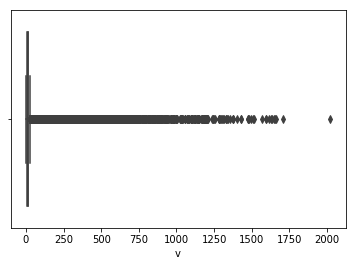

In [10]:
df['v']=df['distance']*60/df['run_time']
sns.boxplot(df.v)

#### Có thể thấy được vận tốc chạy từ 0 -2000  km/h.  8 (percentile  20%) - 16 (percentile 75%). Lý do là tài xế ấn hoàn thành ngay sau khi nhận đơn or quên không ấn hoàn thành.
#### Cần phải loại bỏ những trường hợp gây nhiễu => chỉ lấy vận tốc trong khoảng [8,30] km/h

In [11]:
df1=df[(df.v>=8)&(df.v<30)]

In [12]:
df2=df1[['distance','n_service','lng_0','lat_0','cod','total_fee','lng_1','lat_1','revenue','hour',
        'minute','dow','ss','avg_time','n_address_0','n_address_1','n_hex_0','n_hex_1','run_time']]

In [13]:
X=df2.drop(["run_time"],axis=1)
y=df2["run_time"]

#### Shape data

In [14]:
np.shape(X)

(372947, 18)

### Model

#### Data gồm 18 feature
#### Model dự báo thời gian mà tài xế sẽ giao từ lúc nhận hàng (run_time)
#### Metric: RMSE và MAE

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(X)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True)

In [17]:
model = xgb.XGBRegressor(random_state=1,learning_rate=0.2)
model.fit(x_train,y_train)
#Predict 
ythat = model.predict(x_test)
a1=np.sqrt(mean_squared_error(y_test, ythat))
b1=mean_absolute_error(y_test,ythat)

In [18]:
model=lgb.LGBMRegressor(n_estimators=1000)
model.fit(x_train,y_train)
#Predict 
ythat = model.predict(x_test)
a2=np.sqrt(mean_squared_error(y_test, ythat))
b2=mean_absolute_error(y_test,ythat)

In [19]:
model = GradientBoostingRegressor(random_state=1, n_estimators=300)
model.fit(x_train,y_train)
#Predict 
ythat = model.predict(x_test)
a3=np.sqrt(mean_squared_error(y_test, ythat))
b3=mean_absolute_error(y_test,ythat)

In [20]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(25,),activation='relu',
               solver='adam',
               learning_rate='adaptive',
               max_iter=1000,
               learning_rate_init=0.01,
               alpha=0.01)
model.fit(x_train,y_train)
ythat = model.predict(x_test)
a4=np.sqrt(mean_squared_error(y_test, ythat))
b4=mean_absolute_error(y_test,ythat)

In [21]:
from sklearn.ensemble import VotingRegressor
model1 = xgb.XGBRegressor(random_state=1,learning_rate=0.2)
model2 = lgb.LGBMRegressor()
model3 = GradientBoostingRegressor(random_state=1, n_estimators=300)
model = VotingRegressor([('xgb', model1), ('lgbm', model2), ('gb', model3)])
model.fit(x_train,y_train)
#Predict 
ythat = model.predict(x_test)
a5=np.sqrt(mean_squared_error(y_test, ythat))
b5=mean_absolute_error(y_test,ythat)

#### Kết quả:

In [22]:
data={'model':['xgb','lgbm','gb','mlp','voting'],'rmse':[a1,a2,a3,a4,a5], 'mae':[b1,b2,b3,b4,b5]}
pd.DataFrame(data=data)

,mae,model,rmse
0,6.430506,xgb,9.252155
1,6.167399,lgbm,8.994146
2,6.365807,gb,9.167250
3,6.620899,mlp,9.554671
4,6.332703,voting,9.121664


#### => Dựa vào RMSE và MAE chọn LGBM(LGBMRegressor). MAE: 6.2

### Tuning parameter

In [35]:
params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'root_mean_squared_error',
          'num_leaves': 10,
          'max_depth': 100,
          'learning_rate': 0.09,
          'bagging_fraction': 0.85,
          'feature_fraction': 1,
          'min_split_gain': 0.005,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.15,
          'verbosity': 0,
          'data_random_seed': 17,
          'early_stop': 500,
          'verbose_eval': False,
          'num_rounds': 1000,
        'n_estimators':1000}
# LightGBM dataset formatting 
feature_names = X.columns.tolist()
d_train = lgb.Dataset(x_train, y_train,
                feature_name=feature_names)
d_val = lgb.Dataset(x_test, y_test,
                feature_name=feature_names)
watchlist = [d_train, d_val]
model = lgb.train(params,
    train_set=d_train,
    num_boost_round=params['num_rounds'],
    valid_sets=watchlist,
    verbose_eval=params['verbose_eval'],
    early_stopping_rounds=params['early_stop'])
ythat=model.predict(x_test, num_iteration=model.best_iteration)
np.sqrt(mean_squared_error(y_test, ythat))

/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:116: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


8.987302392664231

### Add feature 
#### (Vận tốc trung bình của từng hexagon trong 20ph trước)
#### - Rmse có giảm khoảng 0.2 nhưng do độ phức tạp của feature nếu chạy trong thực tế => không thêm feature này 

## Chỉ áp dụng với service='BIKE'

In [42]:
df3=df1[df1.service_id.str.contains('BIKE')]

In [47]:
df4=df3[['distance','n_service','lng_0','lat_0','cod','total_fee','lng_1','lat_1','revenue','hour',
        'minute','dow','ss','avg_time','n_address_0','n_address_1','n_hex_0','n_hex_1','run_time']]
X=df4.drop(["run_time"],axis=1)
y=df4["run_time"]

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [55]:
params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'root_mean_squared_error',
          'num_leaves': 10,
          'max_depth': 100,
          'learning_rate': 0.09,
          'bagging_fraction': 0.85,
          'feature_fraction': 1,
          'min_split_gain': 0.005,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.15,
          'verbosity': 0,
          'data_random_seed': 17,
          'early_stop': 500,
          'verbose_eval': False,
          'num_rounds': 1000,
        'n_estimators':1000}
# LightGBM dataset formatting 
feature_names = X.columns.tolist()
d_train = lgb.Dataset(x_train, y_train,
                feature_name=feature_names)
d_val = lgb.Dataset(x_test, y_test,
                feature_name=feature_names)
watchlist = [d_train, d_val]
model = lgb.train(params,
    train_set=d_train,
    num_boost_round=params['num_rounds'],
    valid_sets=watchlist,
    verbose_eval=params['verbose_eval'],
    early_stopping_rounds=params['early_stop'])
ythat=model.predict(x_test, num_iteration=model.best_iteration)
print('RMSE',np.sqrt(mean_squared_error(y_test, ythat)))
print('MAE',mean_absolute_error(y_test,ythat))

/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:116: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSE 7.779222335885472
MAE 5.351020180504443


# *HAN

### Tương tự:
#### - Model: LGBM(LGBMRegressor)
#### - RMSE: 8 và MAE: 5.5

# 2. Accept time

In [56]:
df5=pd.read_csv('./data_HAN_v2.csv')

In [58]:
df5=df5[df5.accept_distance<200]

####  Distribution của khoảng cách nhận đơn và khoảng cách giao hàng

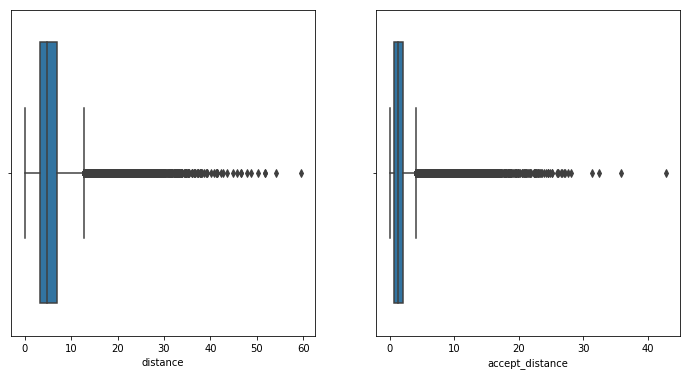

In [59]:
f, ax=plt.subplots(1,2,figsize=(12,6))
ax1=ax[0] 
sns.boxplot(df5.distance, ax=ax1)
ax2=ax[1] 
sns.boxplot(df5.accept_distance,ax=ax2)

#### - Do distribution của khoảng cách, thời gian nhận hàng và giao hàng khác nhau rất nhiều.
#### => sẽ tách biệt thành 2 model riêng biệt (nhận hàng và giao hàng)

In [60]:
df5['accept']=round((df5['board_time'].astype('datetime64')-df5['accept_time'].astype('datetime64')).dt.total_seconds()/60,0)

In [63]:
df5['v']=df5['accept_distance']*60/df5['accept']

In [66]:
df6=df5[(df5.v>=8)&(df5.v<30)]

In [68]:
def toNumeric(dataframe, fromAtt, toAtt):
  from sklearn import preprocessing
  if dataframe[fromAtt].dtype == type(object):
      le = preprocessing.LabelEncoder()# Dummies / One Hot Encoder  
      dataframe[toAtt] = le.fit_transform(dataframe[fromAtt].astype(str))   
  return dataframe

In [69]:
df6 = toNumeric(df6, 'hex_0', 'n_hex_0')
df6 = toNumeric(df6, 'hex_accept', 'hex_accept')
df6 = toNumeric(df6, 'address_accept', 'n_address_accept')
df6 = toNumeric(df6, 'address_0', 'n_address_0')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [70]:
df7=df6[['accept_distance','n_service','accept_lng','accept_lat','cod','total_fee','lng_0','lat_0','revenue','hour',
        'minute','dow','ss','avg_time','n_address_accept','n_address_0','hex_accept','n_hex_0','accept']]

In [71]:
X=df7.drop(['accept'],axis=1)
Y=df7["accept"]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
model=lgb.LGBMRegressor(n_estimators=1000)
model.fit(x_train,y_train)
#Predict 
ythat = np.round(model.predict(x_test),0)
print('RMSE',np.sqrt(mean_squared_error(y_test, ythat)))
print('MAE',mean_absolute_error(y_test,ythat))

RMSE 2.2598230997381483
MAE 1.589197433019458


# Kết luận:
### Delivery time:
#### - model: LGBMRegressor
#### - MAE_SGN: 6.1 (4 service) , 5.3 (Bike)
#### - MAE_HAN: 5.5 (4 service)

### Accept time:
#### - model: LGBMRegressor
#### - MAE: 1.6 (4 service)

## Khó khăn:
#### - Đã sử dụng kmeans, DBscan, mean shift để phân loại ra tập data chứa nhiễu( ấn hoàn thành ngay or quên không ấn hoàn thành...) , nhưng kết quả không khả quan => cần tìm biện pháp cải thiện

In [72]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')